<a href="https://colab.research.google.com/github/rolitta/Deeplearning_classification/blob/main/Landcover_segmentation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install patchify
!pip install tensorflow
!pip install -U segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import random
import tensorflow as tf
from inspect import isgeneratorfunction
from matplotlib.colors import ListedColormap
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda
from keras import backend as bk
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.models import load_model


os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [4]:
minmaxscaler = MinMaxScaler()

In [5]:
!ls -lah '/content/drive/MyDrive/Colab Notebooks/satellite/Semantic segmentation dataset'

total 40K
-rw------- 1 root root  548 May 29  2020  classes.json
-rw------- 1 root root 6.1K May 31  2023  .DS_Store
drwx------ 2 root root 4.0K May 31  2023 'Tile 1'
drwx------ 2 root root 4.0K May 31  2023 'Tile 2'
drwx------ 2 root root 4.0K May 31  2023 'Tile 3'
drwx------ 2 root root 4.0K May 31  2023 'Tile 4'
drwx------ 2 root root 4.0K May 31  2023 'Tile 5'
drwx------ 2 root root 4.0K May 31  2023 'Tile 6'
drwx------ 2 root root 4.0K May 31  2023 'Tile 7'
drwx------ 2 root root 4.0K May 31  2023 'Tile 8'


In [6]:
dataset_root_folder = '/content/drive/MyDrive/Colab Notebooks/satellite/'
dataset_name = "Semantic segmentation dataset"
# Create a directory to save the images
output_dir = '/content/drive/My Drive/Patched_Images'
os.makedirs(output_dir, exist_ok=True)
test_data_folder = '/content/drive/MyDrive/Colab Notebooks/satellite/test_images'

In [7]:
k=0
for path, subdirs, files in os.walk(os.path.join(dataset_root_folder, dataset_name)):
  dir_name = path.split(os.path.sep)[-1]
  #print (dir_name)
  if dir_name == 'images':
    images = os.listdir(path)
    k=k+1
    for i,img_name in enumerate(images):
      if (img_name.endswith ('.jpg')):
        # print(img_name)
        a = True


In [8]:
i

8

In [9]:
image_dataset = []
mask_dataset = []

image_patch_size = 256

for image_type in ['images', 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
    image_extension = 'png'

  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        # print("({}, {})".format(image.size[0],image.size[1]))
        image = np.array(image)
        patched_images = patchify(image, (image_patch_size,  image_patch_size, 3), step = image_patch_size)
        #print(len(patched_images))
        #print(patched_images.shape)
        for i in range(patched_images.shape[0]):
            for j in range(patched_images.shape[1]):
              if image_type == 'images':
                individual_patched_image = patched_images[i,j,:,:]
                #print(individual_patched_image.shape)
                individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
                individual_patched_image = individual_patched_image[0]

                #print(individual_patched_image.shape)
                image_dataset.append(individual_patched_image)
              elif image_type == 'masks':
                individual_patched_mask = patched_images[i,j,:,:]
                individual_patched_mask = individual_patched_mask[0]
                mask_dataset.append(individual_patched_mask)


In [10]:
i

7

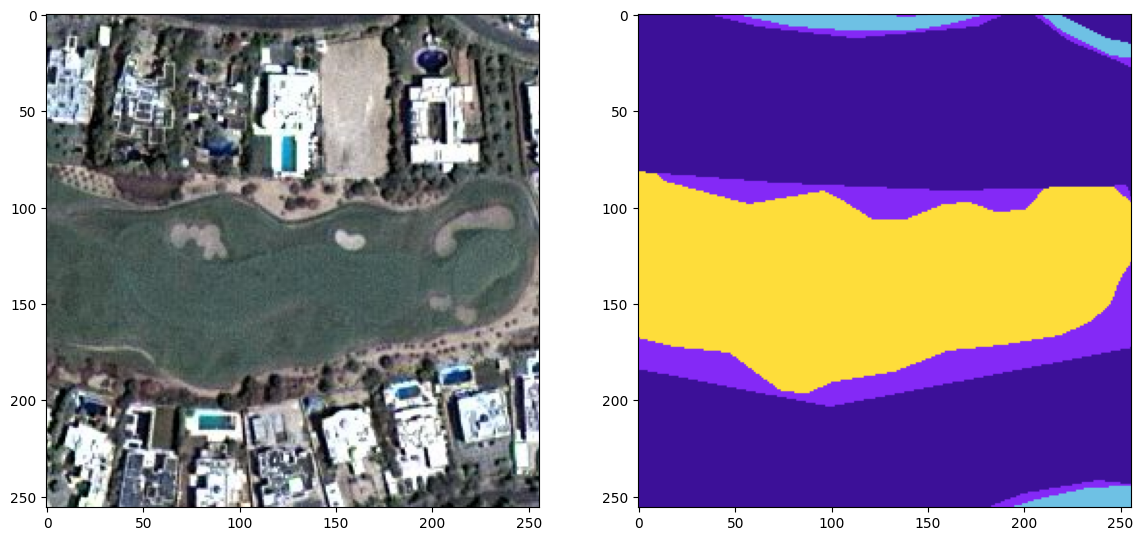

In [11]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [12]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [13]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [14]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

In [15]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [16]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)
labels.shape

(945, 256, 256, 1)

In [17]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [18]:
# Define the colors for each class
colors = [
    (0, 0, 1),       # blue for water
    (0.6, 0.3, 0),   # brown for land
    (0.5, 0.5, 0.5), # grey for road
    (1, 0.5, 0),       # red for building
    (0, 1, 0),       # green for vegetation
    (0, 0, 0)        # black for unlabeled
]

# Create a colormap
cmap = ListedColormap(colors)

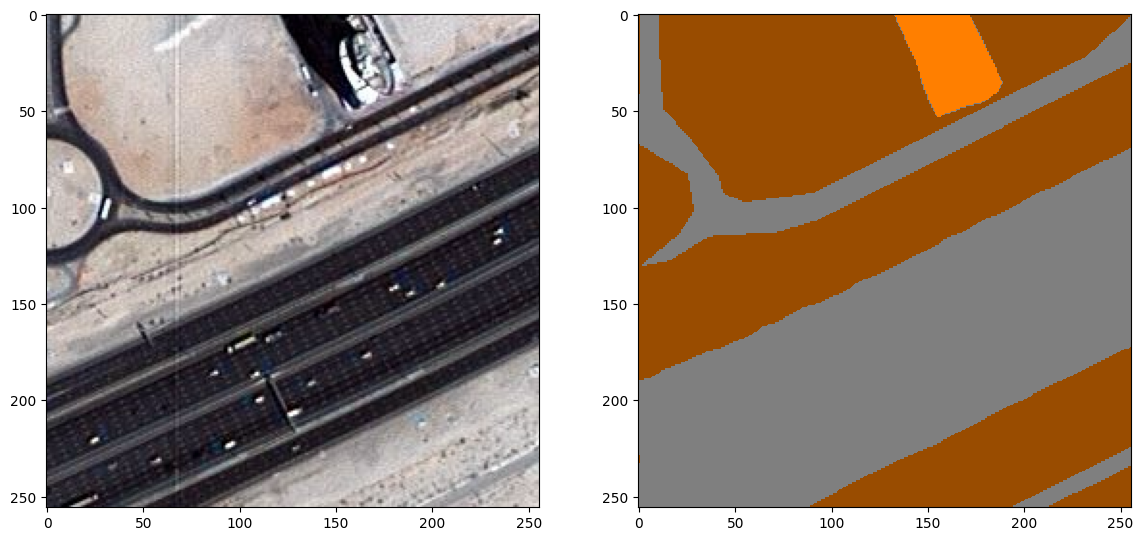

In [19]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
#plt.imshow(mask_dataset[random_image_id])
#plt.imshow(labels[random_image_id][:,:,0])
plt.imshow(labels[random_image_id][:, :, 0], cmap=cmap, vmin=0, vmax=5)  # vmin and vmax to set the range of the colormap


In [20]:
total_classes = len(np.unique(labels))
total_classes

6

In [21]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [22]:
master_trianing_dataset = image_dataset

In [23]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [24]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [25]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]
image_channels

3

**part 2**

In [26]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = bk.flatten(y_true)
  y_pred_flatten = bk.flatten(y_pred)
  intersection = bk.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = ( intersection + 1.0) / (bk.sum(y_true_flatten) + bk.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value


In [27]:
def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(num_filters, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(x)
    x = BatchNormalization()(x)
    return x

def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):
    inputs = Input((image_height, image_width, image_channels))

    c1 = conv_block(inputs, 16)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = conv_block(p1, 32)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = conv_block(p2, 64)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = conv_block(p3, 128)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = conv_block(p4, 256)

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    c6 = conv_block(u6, 128)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = conv_block(u7, 64)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = conv_block(u8, 32)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
    u9 = concatenate([u9, c1])
    c9 = conv_block(u9, 16)

    outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [28]:
metrics = ["accuracy", jaccard_coef]

In [29]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [30]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [31]:
model = get_deep_learning_model()

Generating Loss Function

dice loss > Focal Loss > Total Loss


Total Loss = (Dice loss + (1*Focal Loss)) **bold text**

In [32]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

In [33]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)

In [34]:
focal_loss = sm.losses.CategoricalFocalLoss()

In [35]:
total_loss = dice_loss + (1 * focal_loss)

Model compilation

In [36]:
tf.keras.backend.clear_session()

In [37]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['batch_normalization[0][0

In [39]:
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

model_history = model.fit(X_train, y_train,
                          batch_size=4,
                          verbose=1,
                          epochs=50,
                          validation_data=(X_test, y_test),
                          shuffle=False,
                          callbacks=[early_stopping])

Epoch 1/50
201/201 [==============================] - 47s 108ms/step - loss: 0.9898 - accuracy: 0.6355 - jaccard_coef: 0.3011 - val_loss: 1.0049 - val_accuracy: 0.5556 - val_jaccard_coef: 0.2932
Epoch 2/50
201/201 [==============================] - 15s 72ms/step - loss: 0.9724 - accuracy: 0.6988 - jaccard_coef: 0.3887 - val_loss: 0.9859 - val_accuracy: 0.6105 - val_jaccard_coef: 0.3774
Epoch 3/50
201/201 [==============================] - 15s 72ms/step - loss: 0.9652 - accuracy: 0.7198 - jaccard_coef: 0.4327 - val_loss: 0.9527 - val_accuracy: 0.7483 - val_jaccard_coef: 0.5293
Epoch 4/50
201/201 [==============================] - 15s 73ms/step - loss: 0.9605 - accuracy: 0.7342 - jaccard_coef: 0.4627 - val_loss: 0.9595 - val_accuracy: 0.7345 - val_jaccard_coef: 0.5458
Epoch 5/50
201/201 [==============================] - 15s 73ms/step - loss: 0.9580 - accuracy: 0.7409 - jaccard_coef: 0.4785 - val_loss: 0.9448 - val_accuracy: 0.7791 - val_jaccard_coef: 0.5687
Epoch 6/50
201/201 [=========

In [40]:
history_a = model_history
history_a

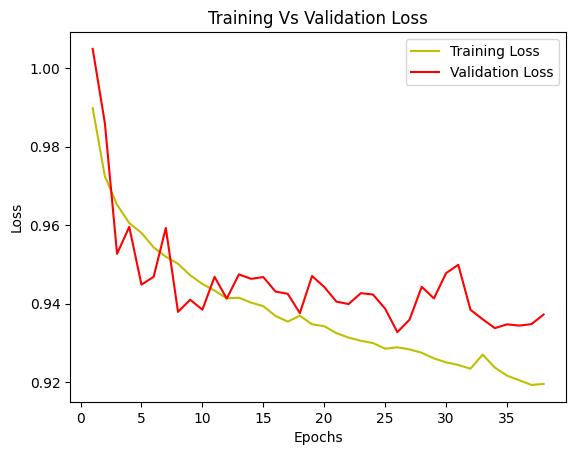

In [41]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

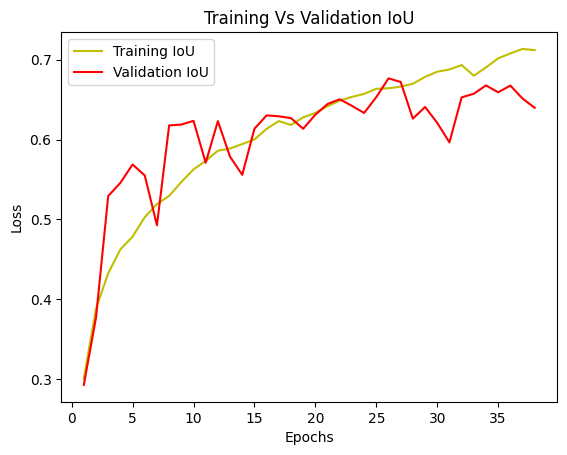

In [42]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


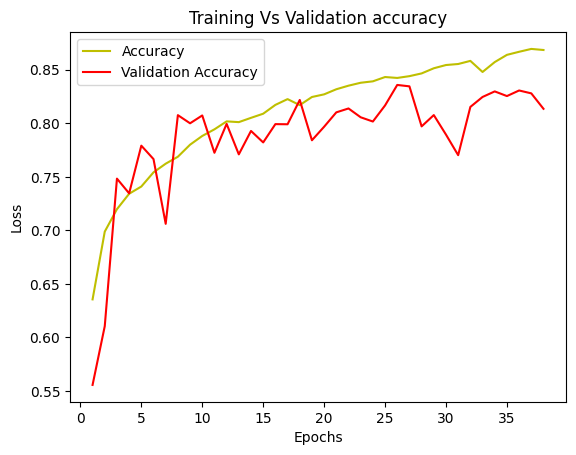

In [43]:
Accuracy = history_a.history['accuracy']
val_accuracy = history_a.history['val_accuracy']
epochs = range(1, len(Accuracy) + 1)
plt.plot(epochs, Accuracy, 'y', label="Accuracy")
plt.plot(epochs, val_accuracy, 'r', label="Validation Accuracy")
plt.title("Training Vs Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [44]:
y_pred = model.predict(X_test)

5/5 [==============================] - 8s 645ms/step


In [45]:
len(y_pred)

142

In [46]:
y_pred_argmax = np.argmax(y_pred, axis=3)

In [47]:
y_test_argmax = np.argmax(y_test, axis=3)

Testing result

In [48]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 2s 2s/step


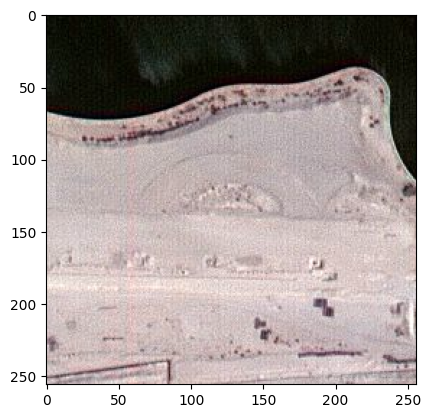

In [49]:
plt.imshow(test_image)

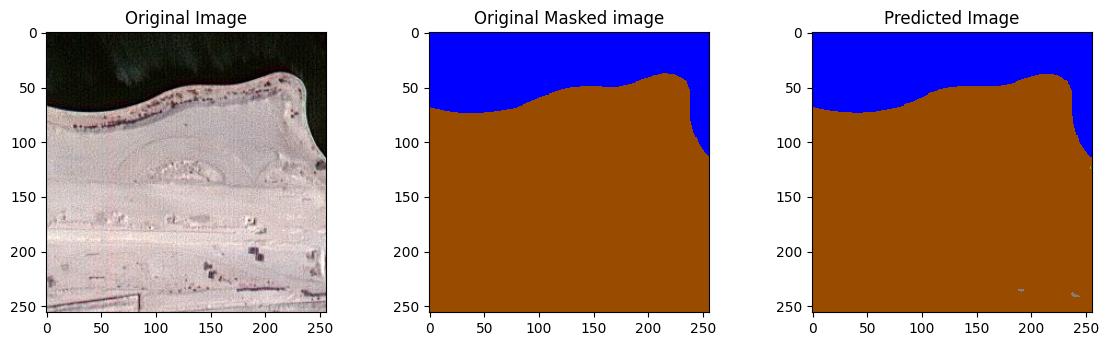

In [50]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)

plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image, cmap=cmap, vmin=0, vmax=5)
#plt.imshow(ground_truth_image)

plt.subplot(233)
plt.title("Predicted Image")
#plt.imshow(predicted_image)
plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=5)

In [51]:

model.save('satellite-imagery1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [52]:
saved_model = load_model('/content/satellite-imagery1.h5',
                         custom_objects=({'dice_loss_plus_1focal_loss': total_loss,
                                          'jaccard_coef': jaccard_coef}))

Test on custom images

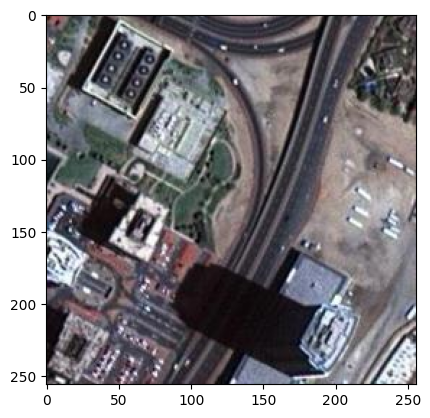

In [53]:
image_path = f'{test_data_folder}/image_2.jpg'
image = Image.open(image_path)
image = image.resize((256,256))
plt.imshow(image)
image = np.array(image)
image = np.expand_dims(image, 0)


In [54]:
image = minmaxscaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
image.shape

(1, 256, 256, 3)

In [55]:
prediction = saved_model.predict(image)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 1s 513ms/step


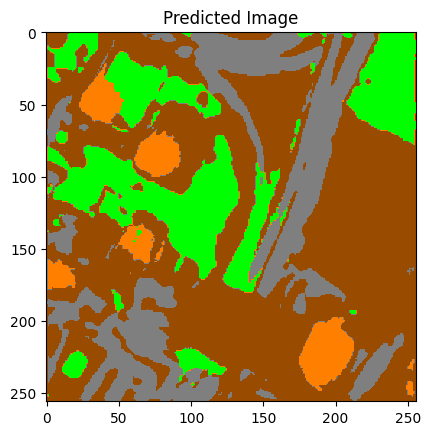

In [56]:
plt.title("Predicted Image")
plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=5)